# Caso Practico

Enlace de [presentacion](!https://www.canva.com/design/DAFXacrIoH0/CKVwmNNgQj4y4F5KZFy9QA/view?utm_content=DAFXacrIoH0&utm_campaign=designshare&utm_medium=link2&utm_source=sharebutton) final

## Enunciado:

En la empresa “Seguros CDF” se comercializa sus productos a través de distintos canales. Estos productos son adquiridos de manera voluntaria por los clientes y pueden ser cancelados en cualquier momento. El equipo comercial ha detectado que muchas de las ventas se cancelan dentro de los primeros 4 meses y necesita definir una estrategia proactiva para retener a sus clientes. Es por ello que se está apoyando en el equipo de Data Analytics de Seguros CDF para que mediante un modelo predictivo pueda ayudar a definir la estrategia más adecuada.


## Planteamiento de la solucion:

Modelo de Clasifiacion binary (binary classification model)

`Target = 1` -> Se cancela el seguro dentro de los primeros 4 meses

`Target = 0` -> No se cancela el seguro dentro de los primeros 4 meses

### Modelos

El modelo entregara la probabilidad `p`, dadas las features de entrada, de que el target = 1 se suscite.

Dependiendo del valor de `p` se tomaran las medidas proactivas respectivas. Teniendo en cuenta que a mayor sea su valor, el modelo esta mas confidente de que se suscite la cancelacion del seguro.

---

> Santiago Madariaga Collado


In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

# Para el modelo base
# import libraries to create a binary classification model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.metrics import roc_curve

import shap
shap.initjs()


# Para el modelo final
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Exploratory Data Analysis

> EDA

In [2]:
# Import the dataset
# read a xlsx file using pandas 
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html

dataset = pd.read_excel('Base_Cancelaciones_UseCase.xlsx')

# El numero del certificado representa un contrato, por lo que es un dato unico
print(f"Certificados unicos: {len(dataset.NUM_CERTIFICADO.unique())} | Total Certificados no nulos: {dataset.NUM_CERTIFICADO.dropna().count()}")

print(f"Clientes unicos:{len(dataset.COD_CLIENTE.unique())} \nClientes duplicados: {dataset.COD_CLIENTE.duplicated().sum()}"  )

dataset.head()

Certificados unicos: 118952 | Total Certificados no nulos: 120000
Clientes unicos:116188 
Clientes duplicados: 3812


,COD_CLIENTE,PRODUCTO,NUM_CERTIFICADO,FECHA_INICIO,FECHA_CANCELACION,FLAG_CANCELADO
0,30bcb9290daee609d26c5780839c0a48e5faf39f65e1f2...,1,c940427a73c497b10f1f223ddb416f7403293120821172...,2021-03-12,2021-03-18 00:00:00,1
1,bad01b3b590275f7b1729f2012b2eb05a820f1217544d7...,4,5d31273ad02e1f9626faed1ee3a9ac7dab01aef1d239bb...,2021-07-23,2021-10-07 00:00:00,1
2,e2350ee66445c6e35dcf05a42684e0625b479762e1cfc3...,1,c0663d4b54e3901f68d9b70d4e2f2b747831be2a23efc7...,2021-09-27,2022-02-01 00:00:00,1
3,8dae800d252d2fbb817ca498bb8cbdf4e77f46a02260e7...,1,1c23156ed8e7de34160f513305d84d30ef00a73e044629...,2022-05-09,-,0
4,9a0f0371a3754818a5dc983ab96bc799e25743821d4bdf...,1,2caa655347e3584e3c977f6ee2fd0834e43213272df493...,2021-09-13,2022-12-12 00:00:00,1


In [3]:
dataset.isna().sum()

COD_CLIENTE          0
PRODUCTO             0
NUM_CERTIFICADO      0
FECHA_INICIO         0
FECHA_CANCELACION    0
FLAG_CANCELADO       0
dtype: int64

 + Se asume que **NUM_CERTICIADO** es la llave primaria de los datos. Es decir, no pueden haber certificados duplicados.

In [4]:
dataset = dataset.drop_duplicates(subset=['NUM_CERTIFICADO'])
dataset.describe()

,PRODUCTO,FLAG_CANCELADO
count,118952.000000,118952.000000
mean,1.706327,0.659695
std,1.576721,0.473814
min,1.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,10.000000,1.000000


In [26]:
dataset.FLAG_CANCELADO.value_counts()

1    78472
0    40480
Name: FLAG_CANCELADO, dtype: int64

In [6]:
# Procesado de la fecha
df_cancelados = dataset[dataset['FLAG_CANCELADO'] == 1].copy()

# Convertir la fecha a datetime
df_cancelados.FECHA_CANCELACION = pd.to_datetime(df_cancelados.FECHA_CANCELACION, format='%Y-%m-%d %H:%M:%S')

In [7]:
dataset.FECHA_INICIO.describe()

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


count                  118952
unique                    649
top       2021-04-30 00:00:00
freq                      410
first     2021-01-02 00:00:00
last      2022-10-31 00:00:00
Name: FECHA_INICIO, dtype: object

In [8]:
dataset.groupby('PRODUCTO').count()

,COD_CLIENTE,NUM_CERTIFICADO,FECHA_INICIO,FECHA_CANCELACION,FLAG_CANCELADO
PRODUCTO,,,,,
1,95777,95777,95777,95777,95777
2,220,220,220,220,220
3,527,527,527,527,527
4,17471,17471,17471,17471,17471
5,46,46,46,46,46
6,2737,2737,2737,2737,2737
7,484,484,484,484,484
8,44,44,44,44,44
9,1563,1563,1563,1563,1563


<AxesSubplot:xlabel='PRODUCTO'>

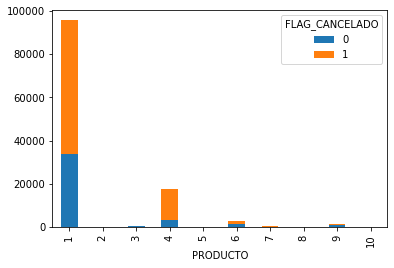

In [9]:
# Fraccion de seguros cancelados, dependiendo del producto contratado
dataset.groupby(['PRODUCTO', 'FLAG_CANCELADO']).size().unstack().plot(kind='bar', stacked=True)

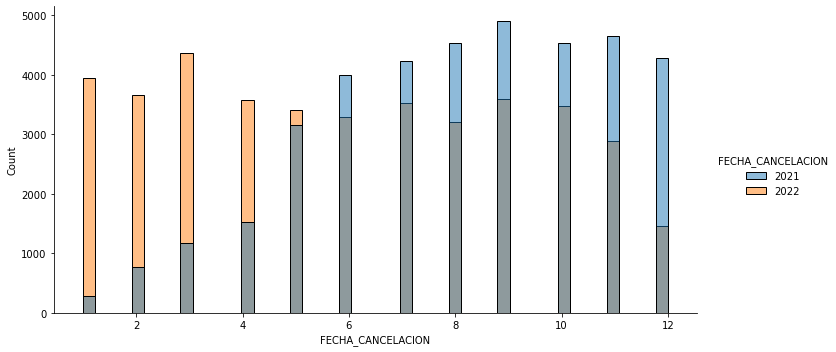

In [10]:
sns.displot(data = df_cancelados, x = df_cancelados.FECHA_CANCELACION.dt.month, hue = df_cancelados.FECHA_CANCELACION.dt.year, palette=["C0", "C1"], height=5, aspect=2)

(0.0, 15.0)

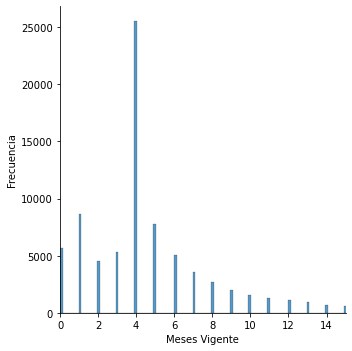

In [11]:
# Crear una columna con el numero de dias que ha estado vigente el seguro
df_cancelados['DIAS_VIGENTE'] = (df_cancelados.FECHA_CANCELACION - df_cancelados.FECHA_INICIO).dt.days

# Crear una columna con el numero de meses que ha estado vigente el seguro
df_cancelados['MESES_VIGENTE'] = round(df_cancelados['DIAS_VIGENTE'] / 30.5)

# sns.countplot(x = df_cancelados.MESES_VIGENTE, data = df_cancelados)
plota = sns.displot(x = df_cancelados.MESES_VIGENTE, data = df_cancelados, height=5, aspect=1)
plota.set(xlabel='Meses Vigente', ylabel='Frecuencia')
plota.axes[0,0].set_xlim(0, 15)

In [12]:
1 - sum(df_cancelados.MESES_VIGENTE > 4)/df_cancelados.count().values[0] # type: ignore

0.6333596696911

In [13]:
# Crear una columna con los dias feriados 
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html

holidays = [datetime.datetime.fromisoformat(f"{y}-{x}") for x in ['01-01',  '07-28', '07-29', '12-25', '12-31'] for y in ['2021', '2022']]

holidays = list(set(np.array(list(map(lambda x: [x + datetime.timedelta(i) for i in range(-7, 3)], holidays))).flatten()))
print(f"N Feriados: {len(holidays)}")


# Crear columnas con los dias de contrato cancelado o creado, si se hicieron cerca de un feriado
dataset['INICIO_FERIADO'] = dataset.FECHA_INICIO.apply(lambda x: x in holidays)
print("mitad")
df_cancelados['CANCELADO_FERIADO'] = df_cancelados.FECHA_CANCELACION.apply(lambda x: x in holidays)

N Feriados: 65
mitad


<AxesSubplot:>

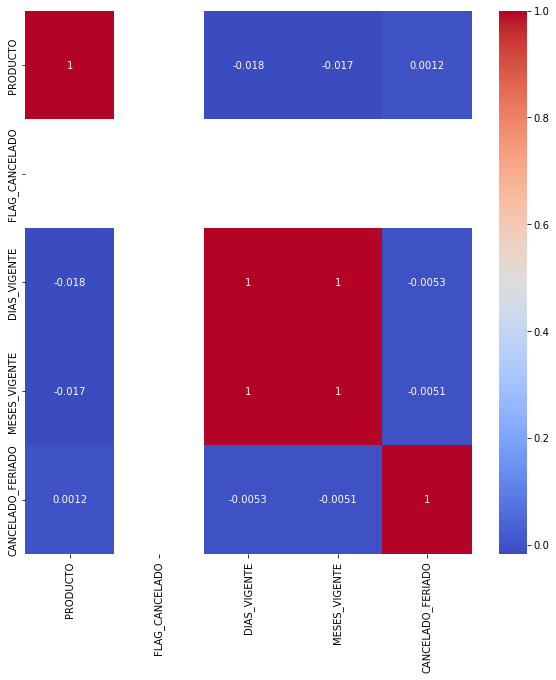

In [14]:
# plot the correlation of the df_cancelados dataframe
plt.figure(figsize=(10, 10))
sns.heatmap(df_cancelados.corr(), annot=True, cmap='coolwarm')

## Procesado de la data

In [15]:

def process(df_: pd.DataFrame, holidays: list, input_cols = ['NUM_CERTIFICADO', 'COD_CLIENTE', 'FECHA_CANCELACION', 'FECHA_INICIO', 'FLAG_CANCELADO', 'DIAS_VIGENTE', 'MESES_VIGENTE'], min_corr = 0.01):
    
    df = df_.copy()
    # Convertir la fecha a datetime
    df.FECHA_INICIO = pd.to_datetime(df.FECHA_INICIO, format='%Y-%m-%d %H:%M:%S')
    df.FECHA_CANCELACION = df.FECHA_CANCELACION.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S') if x != '-' else x) 

    df['INICIO_FERIADO'] = df.FECHA_INICIO.apply(lambda x: x in holidays).astype(int)
    df['SEMANA_INICIO'] = df.FECHA_INICIO.dt.isocalendar().week    

    print("Fechas convertidas al formato")
    # One hot encoding Producto
    df = pd.get_dummies(df, columns=['PRODUCTO'], prefix='PRODUCTO')

    # Normalizar semana de inicio
    minimo = df['SEMANA_INICIO'].min()
    maximo = df['SEMANA_INICIO'].max()
    df['SEMANA_INICIO'] = df['SEMANA_INICIO'].apply(lambda x: (x - minimo) / (maximo - minimo))
    
    # Convertir a la fecha en una funcion periodica
    
    df['INICIO_ENCODED'] = df.FECHA_INICIO.apply(lambda x: x.toordinal())
    minimo = df['INICIO_ENCODED'].min()
    maximo = df['INICIO_ENCODED'].max()
    df['INICIO_ENCODED'] = df['INICIO_ENCODED'].apply(lambda x: (x - minimo) / (maximo - minimo))
    df['INICIO_ENCODED_YEAR'] = df['INICIO_ENCODED'].apply(lambda x: np.sin(x * 2 * np.pi / 365))
    
    print("Incio codificado")
    # Crear una columna con el numero de dias que ha estado vigente el seguro
    df['DIAS_VIGENTE'] = df.apply(lambda x: (x.FECHA_CANCELACION - x.FECHA_INICIO).days if x.FLAG_CANCELADO == 1 else -1, axis = 1)

    # Crear una columna con el numero de meses que ha estado vigente el seguro
    df['MESES_VIGENTE'] = round(df['DIAS_VIGENTE'] / 30.5)
    
    df['LABEL'] = df.MESES_VIGENTE.apply(lambda x: 1 if x <= 4 else 0)
    # Drop  cols no disponibles en tiempo de prediccion para prevenir data leakage
    df.drop(columns=input_cols, inplace=True)

    # Drop cols con poca correlacion con la salida
    corrs = df.corr()
    lb = corrs[corrs.LABEL.abs() < min_corr].index
    df.drop(columns=lb, inplace=True)
    
    return df

In [16]:
# Crear una columna con el numero de la semana de la fecha de inicio
holidays = [datetime.datetime.fromisoformat(f"{y}-{x}") for x in ['01-01',  '07-28', '07-29', '12-25', '12-31'] for y in ['2021', '2022']]

holidays = list(set(np.array(list(map(lambda x: [x + datetime.timedelta(i) for i in range(-7, 3)], holidays))).flatten()))

pro_df = process(dataset, holidays=holidays)

Fechas convertidas al formato
Incio codificado


In [17]:
# split the dataset into train and test
train_df, test_df = train_test_split(pro_df, test_size = 0.2)

# # split the dataset into train and validation
# train_df, val_df = train_test_split(train_df, test_size = 0.2)

## Seleccion de los modelos predictivos

En primer lugar, se definira un modelo base, el cual entregara un rendimiento aceptable y sera usado como punto de partida para el modelo final.

### Modelo base

Se usara un simple modelo de `regression logistica`. Sin embargo, los datos de entrenamiento seran los mismos para ambos modelos. 

### Modelo Final

Los modelos GDBT entregan un excelente rendimiento y escalan muy bien con los recursos necesarios. Es por esto que se usara un modelo `LigthGBM` como modelo final. 

In [18]:
# Fit a logistic regression model with train_df dataset and predict the probability of the test_df dataset
logreg = LogisticRegression(max_iter=10000)
logreg.fit(train_df.drop('LABEL', axis = 1), train_df.LABEL, sample_weight = train_df.LABEL.apply(lambda x: 0.5 if x == 1 else 1))
y_pred = logreg.predict_proba(test_df.drop('LABEL', axis = 1))[:, 1]

1    17854
0     5937
Name: predictions_r, dtype: int64

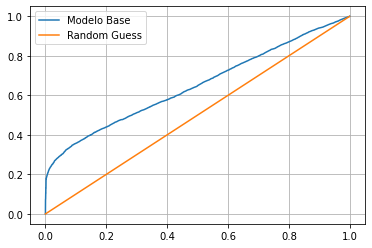

In [19]:
results = pd.DataFrame({'labels': test_df["LABEL"], 'predictions': y_pred})
results['predictions_r'] = results.predictions.apply(lambda x: 1 if x > 0.5 else 0)

# Plot the ROC curvE
fpr, tpr, thresholds = roc_curve(test_df["LABEL"], y_pred)

rand_x = np.arange(0, 1, 1/len(fpr))

plt.plot(fpr, tpr, rand_x, rand_x)
plt.legend(["Modelo Base", "Random Guess"])
plt.grid()

results.predictions_r.value_counts()

<AxesSubplot:>

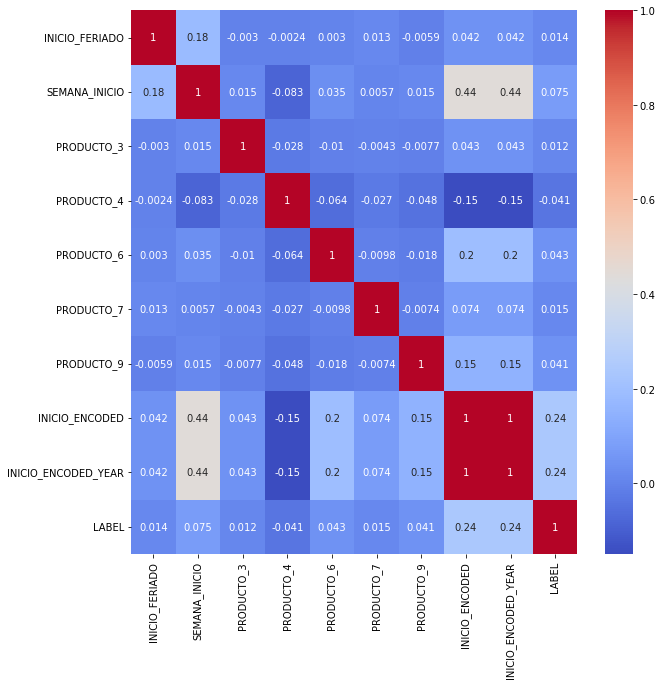

In [20]:
# Plot the correlation of the dataframe

plt.figure(figsize=(10, 10))
sns.heatmap(pro_df.corr(), annot=True, cmap='coolwarm')

In [21]:
# Definircion del modelo lgbm para GridSearch
lgbm = LGBMClassifier()

# Lista de parametros a probar
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'num_leaves': [31, 63, 127],

}


grid_search = GridSearchCV(estimator = lgbm, param_grid = param_grid,
                             cv = 3, n_jobs = -1, verbose = 4)

# Realizar GridSearch
grid_search.fit(train_df.drop('LABEL', axis = 1), train_df.LABEL)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


KeyboardInterrupt: 

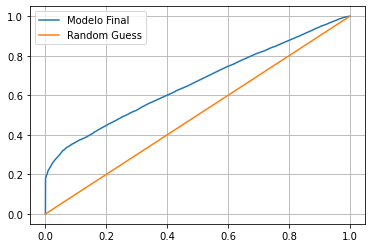

In [ ]:
# Fit a LightGBM model with train_df dataset and predict the probability of the test_df dataset
lgbm = LGBMClassifier(**grid_search.best_params_, class_weight = {0: 1, 1: 0.5})
lgbm.fit(train_df.drop(['LABEL'], axis = 1), train_df.LABEL)
y_pred = lgbm.predict_proba(test_df.drop(['LABEL'], axis = 1))[:, 1]

# Plot the ROC curvE
fpr, tpr, thresholds = roc_curve(test_df["LABEL"], y_pred)

plt.plot(fpr, tpr, rand_x, rand_x)
plt.legend(["Modelo Final", "Random Guess"])
plt.grid()

In [ ]:
# Plot the confussion matrix
def plot_cm(labels, prediccion, threshold):
    # DEfinir la matriz
    cm = confusion_matrix(round(labels), y_pred > threshold)

    # Nomalizar la matriz
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    pass

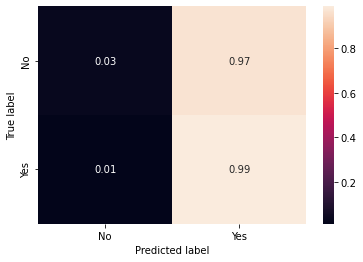

In [ ]:
plot_cm(test_df["LABEL"], y_pred, 0.5)

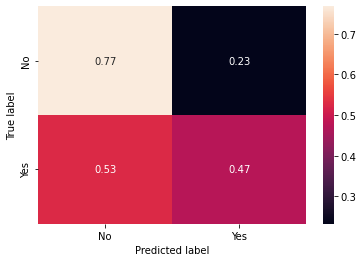

In [ ]:
plot_cm(test_df["LABEL"], y_pred, 0.55)

In [ ]:
# Performa SHAP analysis on the model
explainer = shap.TreeExplainer(lgbm)
explainer_2 = shap.Explainer(lgbm, test_df.drop(['LABEL'], axis = 1))
shap_values = explainer.shap_values(test_df.drop(['LABEL'], axis = 1))
shap_obj = explainer(test_df.drop(['LABEL'], axis = 1))

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


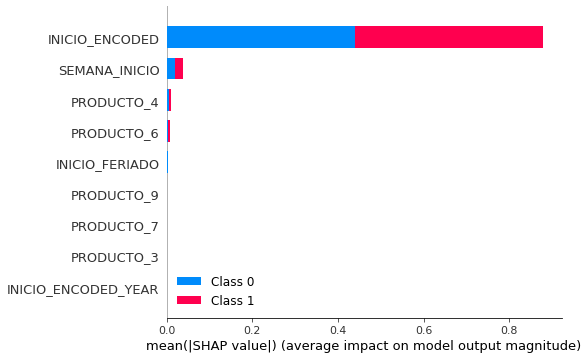

In [ ]:
# Plot the SHAP summary plot
shap.summary_plot(shap_values, test_df.drop(['LABEL'], axis = 1), plot_type="bar")